<a href="https://colab.research.google.com/github/pds2021/a5-nicoelbert/blob/assignment_5/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 20/21*
# Programming Assignment 5 - Create your own App

In this programming assignment you'll build a model that serves as a foundation for your own app. To this end, you will create your own dataset, build a deep learning model on this data, and deploy it!

In [1]:
!pip install -Uqq fastai  # upgrade fastai on colab
from fastai.vision.all import *
from fastai.vision.widgets import *
import os, shutil

__Google Drive integration__

If you want to store and access your downloaded data for this assignment you can use the following code:

In [2]:
from google.colab import drive
drive.mount('/content/drive')




%cd /content/drive/MyDrive/Uni/PDS/FWF

path = Path(r'/content/drive/MyDrive/Uni/PDS/FWF')
data_path = Path(r'/content/drive/MyDrive/Uni/PDS/FWF/data')
data_path.ls()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Uni/PDS/FWF


(#4) [Path('/content/drive/MyDrive/Uni/PDS/FWF/data/DE'),Path('/content/drive/MyDrive/Uni/PDS/FWF/data/AF'),Path('/content/drive/MyDrive/Uni/PDS/FWF/data/US'),Path('/content/drive/MyDrive/Uni/PDS/FWF/data/NL')]

## Develop an Application Idea

___Free your mind - this part is totally up to you.___

Think of an app that you'd like to build.
*   What useful app have you been missing?
*   Do you have any hobbies an app could be helpful for?
*   Is this a suitable classification or regression task? 
*   How could you get the data?


My dear friend sheldon and I are happy to welcome you to 
#Fun with Flags

<img src="http://eastward.de/wp-content/uploads/2020/12/title.png" width="500"/>

## Creating your own Dataset

Now you need to construct a dataset that allows you to train a model for your app. You learned about how to create a dataset in Lecture 7.

Here, you can follow the steps from the lecture or look into the following ressources:

*   A [tool](https://github.com/toffebjorkskog/ml-tools/blob/master/gi2ds.md) for excluding irrelevant images from Google Image Search results beforehand by @melonkernel
*   See this [post](https://www.christianwerner.net/tech/Build-your-image-dataset-faster/) about an alternative image downloader/cleaner by @cwerner
*   Of course, you can use your own data/images :) 

In [3]:
#in this application I'd like to classify all Flags of a 241 countries long list
#https://gist.github.com/marijn/396531/188caa065e3cd319fed7913ee3eecf5eec541918#file-countries-txt

#use testlist for whole code to improve performance
testlist = ['DE','AF','US','NL']

df_countries = pd.read_csv('/content/drive/MyDrive/Uni/PDS/FWF/countries.CSV')


dict_countrynames = df_countries.set_index('Code').to_dict()['Country']
list_countrycodes= testlist#df_countries['Code'].tolist()



#create list and Dictonary from Countries
print(list_countrycodes)
print(dict_countrynames)


#create directorys once 

"""
for cc in list_countrycodes:
  os.mkdir('data/{}'.format(cc))

"""

"""
#if needed delete directorys
for cc in list_countrycodes:
  os.rmdir('data/{}'.format(cc))
"""

#restart variable 
restart=False



['DE', 'AF', 'US', 'NL']
{'AF': 'Afghanistan', 'AL': 'Albania', 'DZ': 'Algeria', 'AS': 'American Samoa', 'AD': 'Andorra', 'AO': 'Angola', 'AI': 'Anguilla', 'AQ': 'Antarctica', 'AG': 'Antigua And Barbuda', 'AR': 'Argentina', 'AM': 'Armenia', 'AW': 'Aruba', 'AU': 'Australia', 'AT': 'Austria', 'AZ': 'Azerbaijan', 'BS': 'Bahamas', 'BH': 'Bahrain', 'BD': 'Bangladesh', 'BB': 'Barbados', 'BY': 'Belarus', 'BE': 'Belgium', 'BZ': 'Belize', 'BJ': 'Benin', 'BM': 'Bermuda', 'BT': 'Bhutan', 'BO': 'Bolivia', 'BA': 'Bosnia And Herzegovina', 'BW': 'Botswana', 'BV': 'Bouvet Island', 'BR': 'Brazil', 'IO': 'British Indian Ocean Territory', 'BN': 'Brunei Darussalam', 'BG': 'Bulgaria', 'BF': 'Burkina Faso', 'BI': 'Burundi', 'KH': 'Cambodia', 'CM': 'Cameroon', 'CA': 'Canada', 'CV': 'Cape Verde', 'KY': 'Cayman Islands', 'CF': 'Central African Republic', 'TD': 'Chad', 'CL': 'Chile', 'CN': 'China', 'CX': 'Christmas Island', 'CC': 'Cocos (keeling) Islands', 'CO': 'Colombia', 'KM': 'Comoros', 'CG': 'Congo', 'CD':

### 1. Dowload the data 
- You may use the helper functions from the lecture to get the image URLs
- Create a new folder at your defined `path`
- Use `download_image` to download the images into the corresponding (sub-)directories

In [4]:
import requests
import re
import json
from fastcore.foundation import L
#function to return image urls for given terms from ddg -> from VL07

def search_images_ddg(key,max_n=100):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
    (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api and 
    https://github.com/fastai/fastbook/blob/master/utils.py)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0',
                 'referer': 'https://duckduckgo.com/'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass


#deletefunction from  https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder

#Function to clean a given folder

def clean_folder(key):
    dest = (path/'data/{}'.format(key))
    folder =  dest
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:

#Download data
if restart:
  for cc in list_countrycodes:
    c = dict_countrynames[cc]
    dest = (path/'data/{}'.format(cc))
    dest.mkdir(exist_ok=True)
    clean_folder(cc)
    results = search_images_ddg(f'{c} flag',max_n = 50)
    download_images(dest, urls=results)
    results = search_images_ddg(f'{c} flag stick',max_n = 30)
    download_images(dest, urls=results)
    results = search_images_ddg(f'{c} flag badge',max_n = 10)
    download_images(dest, urls=results)
    results = search_images_ddg(f'{c} flag post',max_n = 10)
    download_images(dest, urls=results)
else: print("no restart")


no restart


### 2. Verify Images
- First, create a list of all your images
- Use `verify_images` and `unlink` to remove broken images

In [6]:
dict_filenames = {}
verify_check = True

for cc in list_countrycodes:
  fns = get_image_files(data_path/cc)
  failed = verify_images(fns)
  failed.map(Path.unlink)
  dict_filenames[cc] = get_image_files(data_path/cc) #fill dict_filenames with verified filnamesf
  print("{} contains {} files and {} are corrupt, so {} remain".format(cc,len(fns),len(failed),len(dict_filenames[cc])))
  if len(dict_filenames[cc]) != (len(fns)-len(failed)):
    print("Error: Inital, Failed and Remaing do not match!!!")
    verify_check = False

if verify_check:
  print("Inital, Failed and Remaining match correctly")
else: 
  print("error in match of inital, failed and remaining")

DE contains 68 files and 0 are corrupt, so 68 remain
AF contains 63 files and 0 are corrupt, so 63 remain
US contains 59 files and 0 are corrupt, so 59 remain
NL contains 66 files and 0 are corrupt, so 66 remain
Inital, Failed and Remaining match correctly


### 3. Create the DataBlock
For this, you need to think of:
- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

Use `RandomResizedCrop` for `item_tfms`with an image size of 224 px, and the appropriate `aug_transforms` as `batch_tfms`.

In [24]:
#define transformations
my_item_tfms = [RandomResizedCrop(128, min_scale=0.3), Resize(224)]

#create Datablock

db_countries = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=my_item_tfms,
    batch_tfms=aug_transforms())

dls = db_countries.dataloaders(data_path)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


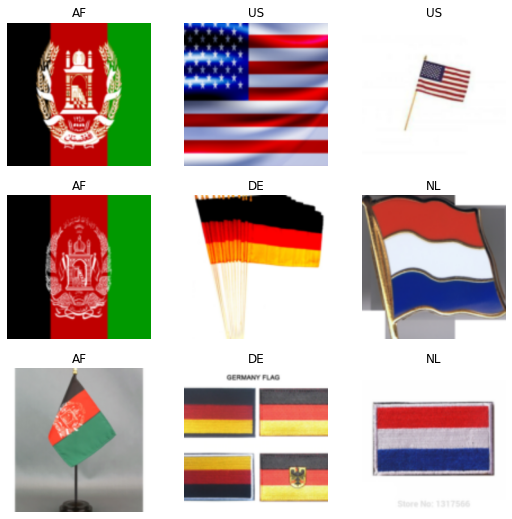

### 4. Create the DataLoaders

In [9]:
# Write your code here
dls = db_countries.dataloaders(data_path,batch_size=64)

### 5. Take a look at some of your pictures. 
Does everything look as expected?

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


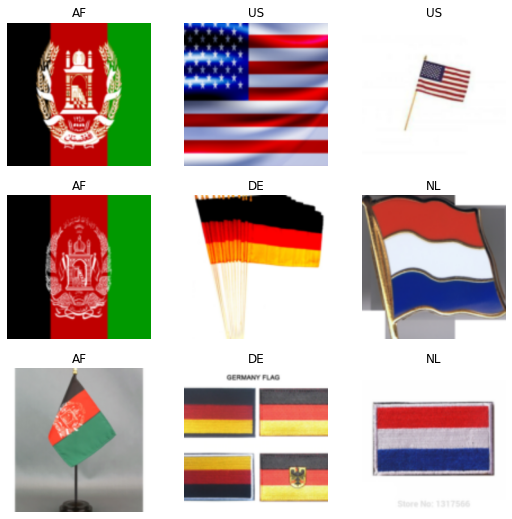

In [27]:
# Write your code here
dls.valid.show_batch(max_n=9)

In [29]:
len(dls.vocab)

4

## Modeling

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


### 6. Create a learner

Create an appropriate learner for your data
- Choose an appropriate model [architecture](https://fastai1.fast.ai/vision.models.html)
- Choose appropriate [metrics](https://docs.fast.ai/metrics.html) for your task

In [32]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.save('stage-0')

Path('models/stage-0.pth')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0020892962347716093)

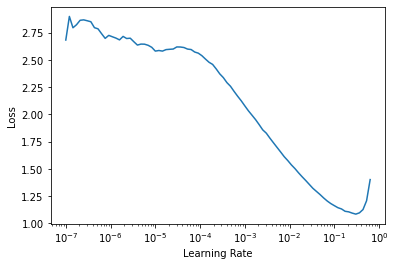

In [34]:
if restart:
  learn.lr_find()
else: print("no restart")

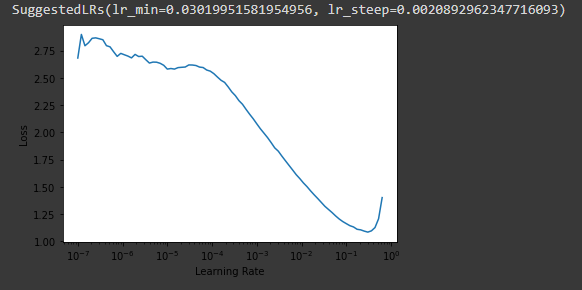

### 7. Fit the model

Use your knowdledge on model training to fit your model!

In [12]:
# Write your code here

### 8. Evaluate the model

You' ve already seen many ways to evaluate a model. Evaluate your model in a qualitative and quantitative manner.

In [13]:
# Write your code here

### 9. Clean your data

Based on the evaluation, you may want to clean your data using the `ImageClassifierCleaner`.
- Remeber to delete the selected data after using the cleaner:
    ```python
    for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    ```
    
    
- Once we've cleaned up our data, we can retrain our model. 



In [14]:
# Write your code here

## Turning Your Model into an Online Application

Now, take your app into production. You can follow the steps from the lecure:

- Export your model via `learn.export`
- Upload your model to [Github Releases](https://docs.github.com/en/free-pro-team@latest/github/administering-a-repository/about-releases) to make it publicly available at your repository.
- Create and upload a new notebook that only contains the necassary code and IPython widgets for your App. 
    - Remeber to download the exported model from *Github Releases*
    - Include a brief description of your app and the functionalities
- Publish your web app on [Binder](https://mybinder.org/) using Voilà

You can use the [example](https://github.com/pds2021/course/blob/main/nbs/07_Bear_App.ipynb) from the lecture as an orientation.

If you're familiar with the world of web application development, you're free to use these skills and all your tools and ressources!

In [15]:
# Write your code here

## Finally, Provide a Link to Your App

In [16]:
# Provide the link to your web app